In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Problem 1

In [2]:
MARKER_SIZE = 100
DATA_COLOR = 'black'
ERROR_COLOR = 'darkred'
POLYNOMIAL_FIT_COLORS = ['orange', 'royalblue', 'darkgreen', 'pink']
N_OBSERVATIONS = 20
NOISE_STD = 0.3

x = 2 * (np.random.rand(N_OBSERVATIONS) - .5)
x_grid = np.linspace(-1, 1, 100)

def f(x):
    return x + np.sin(1.5 * x)


def sample_fx_data(shape, noise_std=NOISE_STD):
    return f(x) + np.random.randn(*shape) * noise_std


def plot_fx_data(y=None):
    y = y if y is not None else sample_fx_data(x.shape)
    fig, axs = plt.subplots(figsize=(6, 6))
    plt.plot(x_grid, f(x_grid), color=DATA_COLOR, label='f(x)')
    plt.scatter(x, y, s=MARKER_SIZE, edgecolor=DATA_COLOR, facecolors='none', label='y')


(-2.0, 2.0)

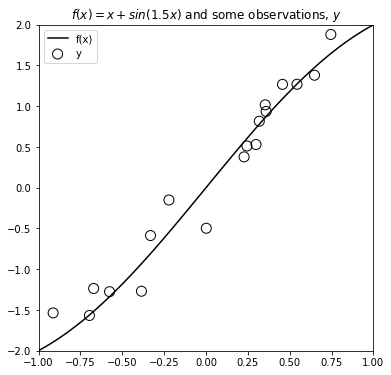

In [3]:
y = sample_fx_data(x.shape)
plot_fx_data(y)
plt.legend()
plt.title(f'$f(x) = x + sin(1.5x)$ and some observations, $y$')
plt.xlim([-1, 1])
plt.ylim([-2, 2])

Text(0.5, 1.0, 'Various Polynomial Functions Fit to Observations')

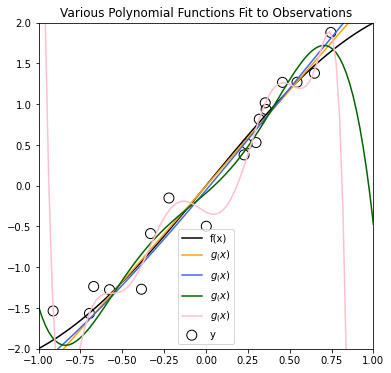

In [4]:
plot_fx_data(y)

polynomial_degrees = [1, 3, 5, 10]
theta = {}
fit = {}
for ii, degree in enumerate(polynomial_degrees):
    theta[degree] = np.polyfit(x, y, degree)
    fit[degree] = np.polyval(theta[degree], x_grid)
    plt.plot(x_grid, fit[degree], POLYNOMIAL_FIT_COLORS[ii], label=f"$g_(x)$")
plt.legend()
plt.xlim([-1, 1])
plt.ylim([-2, 2])
plt.title("Various Polynomial Functions Fit to Observations")

It's not clear which of the estimators, if any, are underfitting. The most likely candidate however would be $g_1$ since it is the closest to a linear line and therefore would not be able to capture all the relationships in the data. However, it is clear that $g_{10}$ is overfitting. As a 10th degree polynomial, it is likely capturing nuances in the test data that do not actually apply to the data as a whole.

Text(0.5, 0.98, 'Model Fits Given Random Samples Around f(x)')

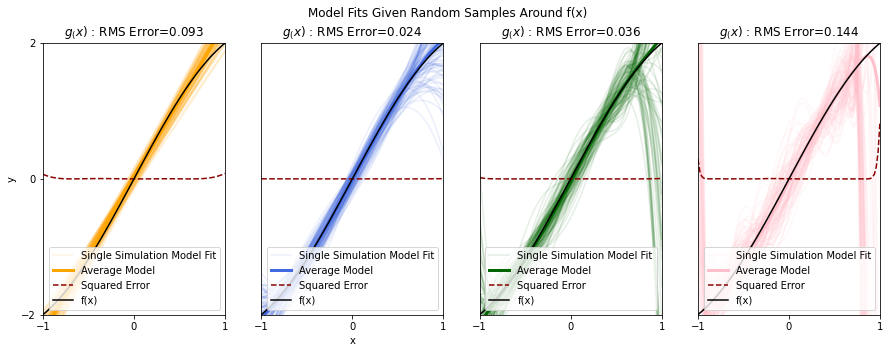

In [5]:
from collections import defaultdict

n_simulations = 100
simulation_fits = defaultdict(list)
polynomial_complexity = [1, 5, 10, 15]
for sim in range(n_simulations):
    y_simulation = sample_fx_data(x.shape)
    for degree in polynomial_degrees:
        theta_tmp = np.polyfit(x, y_simulation, degree)
        simulation_fits[degree].append(np.polyval(theta_tmp, x_grid))

def error_function(pred, actual):
    return (pred - actual) ** 2

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for ii, degree in enumerate(polynomial_degrees):
    plt.sca(axs[ii])
    for jj, fit in enumerate(simulation_fits[degree]):
        label = 'Single Simulation Model Fit' if jj == 0 else None
        plt.plot(x_grid, fit, color=POLYNOMIAL_FIT_COLORS[ii], alpha=.1, label=label)

    average_fit = np.array(simulation_fits[degree]).mean(0)
    squared_error = error_function(average_fit, f(x_grid))
    rms = np.sqrt(squared_error.mean())
    plt.plot(x_grid, average_fit, color=POLYNOMIAL_FIT_COLORS[ii], linewidth=3, label='Average Model')
    plt.plot(x_grid, squared_error, '--', color=ERROR_COLOR, label='Squared Error')
    plt.plot(x_grid, f(x_grid), color='black', label='f(x)')
    plt.yticks([])
    if ii == 1:
        plt.xlabel('x')
    elif ii == 0:
        plt.ylabel('y')
        plt.yticks([-2, 0, 2])

    plt.xlim([-1, 1])
    plt.ylim([-2, 2])
    plt.xticks([-1, 0, 1])
    plt.title(f"$g_(x)$ : RMS Error={np.round(rms, 3)}")
    plt.legend(loc='lower right')
plt.suptitle('Model Fits Given Random Samples Around f(x)')

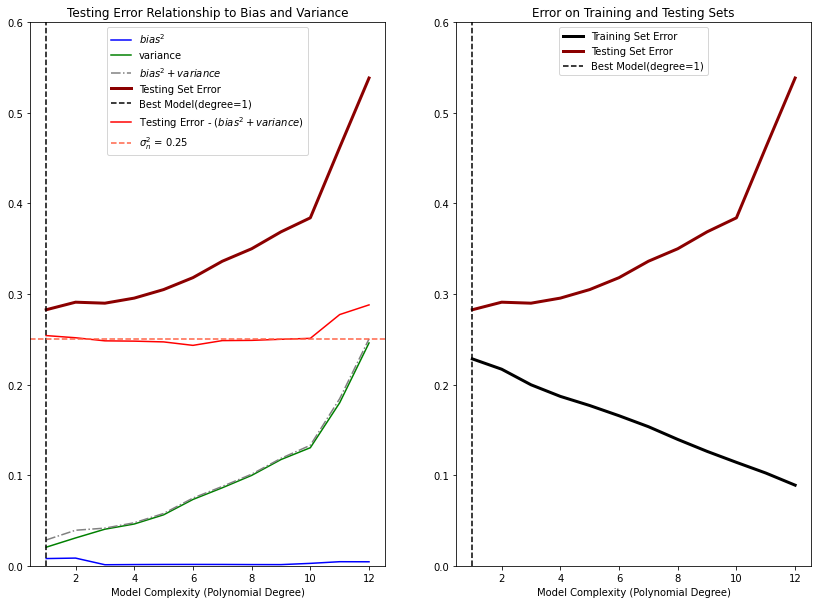

In [6]:
np.random.seed(124)
n_observations_per_dataset = 25
n_datasets = 100
max_poly_degree = 12  # Maximum model complexity
model_poly_degrees = range(1, max_poly_degree + 1)

NOISE_STD = .5
percent_train = .8
n_train = int(np.ceil(n_observations_per_dataset * percent_train))

# Create training/testing inputs
x = np.linspace(-1, 1, n_observations_per_dataset)
x = np.random.permutation(x)
x_train = x[:n_train]
x_test = x[n_train:]

# logging variables
theta_hat = defaultdict(list)

pred_train = defaultdict(list)
pred_test = defaultdict(list)

train_errors = defaultdict(list)
test_errors = defaultdict(list)

# Loop over datasets
for dataset in range(n_datasets):

    # Simulate training/testing targets
    y_train = f(x_train) + NOISE_STD * np.random.randn(*x_train.shape)
    y_test = f(x_test) + NOISE_STD * np.random.randn(*x_test.shape)

    # Loop over model complexities
    for degree in model_poly_degrees:
        # Train model
        tmp_theta_hat = np.polyfit(x_train, y_train, degree)

        # Make predictions on train set
        tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
        pred_train[degree].append(tmp_pred_train)

        # Test predictions
        tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
        pred_test[degree].append(tmp_pred_test)

        # Mean Squared Error for train and test sets
        train_errors[degree].append(np.mean(error_function(tmp_pred_train, y_train)))
        test_errors[degree].append(np.mean(error_function(tmp_pred_test, y_test)))


def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (E[g(x)] - f(x))^2, averaged across all trials
    return np.mean((average_model_prediction - f(x_test)) ** 2)


def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (g(x) - E[g(x)])^2, averaged across all trials
    return np.mean((pred_test - average_model_prediction) ** 2)


complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in model_poly_degrees:
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]


# Visualizations
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

## Plot Bias^2 + variance
plt.sca(axs[0])
plt.plot(model_poly_degrees, bias_squared, color='blue', label='$bias^2$')
plt.plot(model_poly_degrees, variance, color='green', label='variance')
plt.plot(model_poly_degrees, np.array(bias_squared) + np.array(variance),  linestyle='-.', color='gray', label='$bias^2 + variance$')
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.plot(model_poly_degrees, np.array(complexity_test_error) - (np.array(bias_squared) + np.array(variance)), color='red', label='Testing Error - ($bias^2 + variance$)')
plt.axhline(NOISE_STD **2, color='tomato', linestyle='--', label=f'$\sigma_{"n"}^2$ = {round(NOISE_STD**2, 3)}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylim([0, .6]);
plt.legend()
plt.title('Testing Error Relationship to Bias and Variance')

## Plot Train / Test Set Error
plt.sca(axs[1])
plt.plot(model_poly_degrees, complexity_train_error, label='Training Set Error', linewidth=3, color=DATA_COLOR)
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.ylim([0, .6]);
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.title('Error on Training and Testing Sets')
plt.legend(loc='upper center')

THe model with the smallest Mean Squared Error is the second one, which has a complexity of 1. The bias of this model is 0.0894 and variance is 0.02054.

# Problem 2

In [7]:
# loading in data 
df = pd.read_csv('Social_Network_Ads.csv')
X = df.iloc[:, [1, 2, 3]].values
Y = df.iloc[:, -1].values

# encoding gender column
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# splitting data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

# feature scaling on the train and test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# training KNN classifier
classifier = KNeighborsClassifier(n_neighbors=4, 
                                  metric='minkowski', 
                                  p=2)
classifier.fit(X_train, Y_train)

# predicting the output for the test set
Y_pred = classifier.predict(X_test)

# metrics
accuracy = accuracy_score(Y_test,Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print('Misclassification Error: ', 1 - accuracy)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F-1 Score: ', 2 * ((precision * recall) / (precision + recall)))

Misclassification Error:  0.08750000000000002
Accuracy:  0.9125
Precision:  0.9285714285714286
Recall:  0.8387096774193549
F-1 Score:  0.8813559322033899


Text(0, 0.5, 'Misclassification Error')

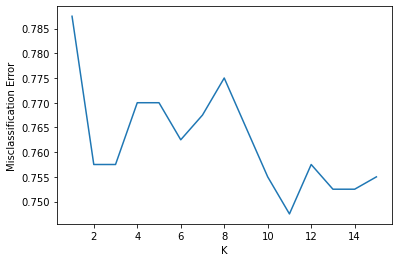

In [8]:
K = list(range(1, 16))
scores = []

for k in K:
  classifier = KNeighborsClassifier(n_neighbors=k, 
                                    metric='minkowski', 
                                    p=1)
  score = cross_val_score(classifier, X, Y, cv=5, scoring='accuracy')
  scores.append(score.mean())

plt.plot(K, scores)
plt.xlabel('K')
plt.ylabel('Misclassification Error')

Text(0, 0.5, 'Misclassification Error')

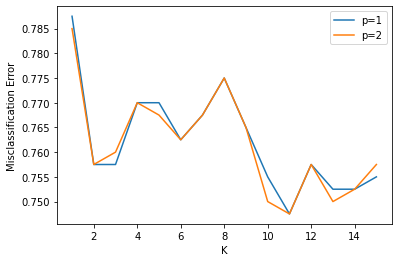

In [9]:
scores2 = []

for k in K:
  classifier = KNeighborsClassifier(n_neighbors=k, 
                                    metric='minkowski', 
                                    p=2)
  score = cross_val_score(classifier, X, Y, cv=5, scoring='accuracy')
  scores2.append(score.mean())

plt.plot(K, scores)
plt.plot(K, scores2)
plt.legend(['p=1', 'p=2'])
plt.xlabel('K')
plt.ylabel('Misclassification Error')

In [10]:
MSE = [1 - score for score in scores]
print('When p=1 (Manhattan), the best value for k is', K[np.argmin(MSE)])

MSE = [1 - score for score in scores2]
print('When p=2 (Euclidean), the best value for k is', K[np.argmin(MSE)])

print('The best classifier is when', K[np.argmin(scores)], 'for both p=1 and p=2')

When p=1 (Manhattan), the best value for k is 1
When p=2 (Euclidean), the best value for k is 1
The best classifier is when 11 for both p=1 and p=2


# Problem 3

1. - Algorithm 1: 25 TP, 5 FN, 15 FP, 55 TN 
  - Algorithm 2: 20 TP, 10 FN, 10 FP, 60 TN 


2. Because we want to optimize for negative classes, and we have an imbalanced dataset, the better metric to use is balanced accuracy. This is because balanced accuracy will take into account the number of negative examples that were classified, whereas the F1 score does not consider this at all. For algorithm 1, the balanced accuracy is 0.81 and the F1 score is 0.71. For algorithm 2, the balanced accuracy is 0.76 and the F1 score is 0.67. As we can see, the balanced accuracy values are higher for both algorithms. Therefore, the friend is correct.

3. Yes, the advice of my friend did help in identifying the better algorithm.

4. In addition to balanced accuracy, we can also use recall, specificity, and an ROC curve.

# Problem 4

1. - C: This must be a positive float, and it represents the inverse of the regularization strength. This means that higher values indicate less regularization, and lower values indicate mroe regularization done to the data. Defaults to 1.0.
  - solver: Takes one of the following: ‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’. This is the algorithm which will be used for optimization. Defaults to 'lbfgs'
  - penalty: Takes one of the following: ‘l1’, ‘l2’, ‘elasticnet’, None. It specifies the norm of the penalty, so None means no penalty is added, 'l1' adds a L1 penalty term, etc. Defaults to 'l2'
  - multi_class: Takes on of the following: ‘auto’, ‘ovr’, ‘multinomial’. When 'ovr' is used, a binary problem is fitted for each label. If 'multinomial', the multinomial loss fit across the probability distribution is used. Defaults to 'auto', which chooses 'ovr' when the data is binary or if solver='liblinear' and 'multinomial' otherwise.

2. 'l1' stands for L1 Regularization, which adds the coefficient as a penalty term to the loss function. 'l2' stands for L2 Regularization, which adds a sqaured coefficient to the loss function. Therefore, 'l1' reduces the less important features' coefficients to zero over multiple iterations which might entirely remove those features. 

In [11]:
iris_dataset = datasets.load_iris()
X = iris_dataset.data
Y = iris_dataset.target

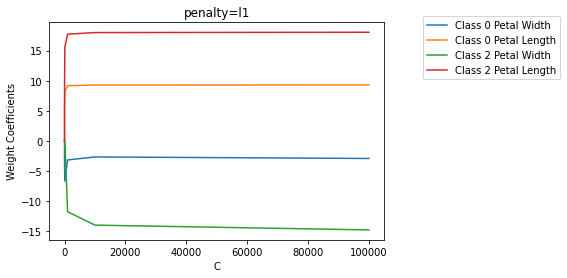

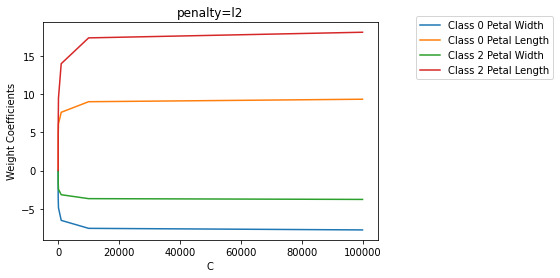

In [12]:
W = []
for penalty in ['l1', 'l2']:
  widths_class0 = []
  lengths_class0 = []
  widths_class2 = []
  lengths_class2 = [] 
  C = [10e-4, 10e-3, 10e-2, 10e-1, 1, 10, 100, 1000, 10000, 100000]
  w = []
  for c in C:
    lr = LogisticRegression(solver='liblinear',
                            C=c, 
                            penalty=penalty,
                            multi_class='ovr')
    lr.fit(X, Y)

    class0 = lr.coef_[0]
    class2 = lr.coef_[2]

    widths_class0.append(class0[2])
    lengths_class0.append(class0[3])
    widths_class2.append(class2[2])
    lengths_class2.append(class2[3])

  w.append(widths_class0)
  w.append(lengths_class0)
  w.append(widths_class2)
  w.append(lengths_class2)
  W.append(w)

  plt.plot(C, widths_class0)
  plt.plot(C, widths_class2)
  plt.plot(C, lengths_class0)
  plt.plot(C, lengths_class2)
  plt.legend(['Class 0 Petal Width', 
              'Class 0 Petal Length', 
              'Class 2 Petal Width', 
              'Class 2 Petal Length'],
             bbox_to_anchor=(1.1, 1.05))
  plt.xlabel('C')
  plt.ylabel('Weight Coefficients')
  plt.title(f'penalty={penalty}')
  plt.show()

Based on the graphs above, as C increases, the weights of petal length and petal width increase and decrease respectively up until a certain point. The rate of change is very steep for low values of C, but as C increases, the change in the weights change less and less between values of C. Additionally, when penalty='l1', this change is very sharp. This is possibly because L1 Regularization essentially removes the irrelevant features from the model, so the change happens very fast. But when penalty='l2', the change is a little smoother, which could be because L2 Regularization does not remove the irrelevant features as quickly.

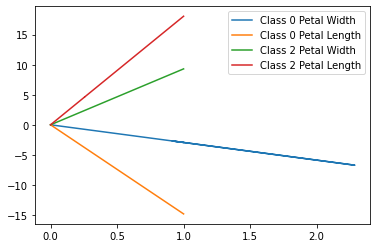

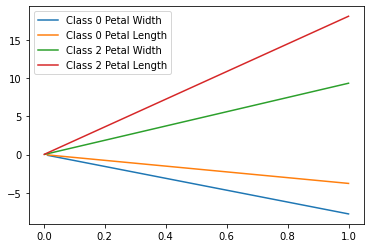

In [13]:
for w in W:
  norms = []
  for v in w:
    norm = []
    for i in range(len(v)):
      norm.append(np.linalg.norm(v[i]) / np.linalg.norm(v[-1]))
    norms.append(norm)

  for i in range(len(w)):
    plt.plot(norms[i], w[i])
  plt.legend(['Class 0 Petal Width','Class 0 Petal Length','Class 2 Petal Width','Class 2 Petal Length'])
  plt.show()

Based on the graph above, at low values of L2 norm, all the coefficients are close to one another. However, as the L2 norm increases, the distance between the coefficients gets greater and greater, especially when we compare the coefficients for petal width and petal length for both classes. This makes sense, because when the value of C increases, the model accounts for less regularization, meaning the amount of variance in the model increases. Therefore, the distance between the coefficients of the features will increase. 

# Problem 5


In [14]:
from scipy.io import arff
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time

In [15]:
file = arff.loadarff('mnist_784.arff')
df = pd.DataFrame(file[0])
df['class'] = df['class'].astype('int32')
Y = df['class'].values
X = df.drop('class', axis='columns').values

(70000, 784)
(70000,)


<BarContainer object of 10 artists>

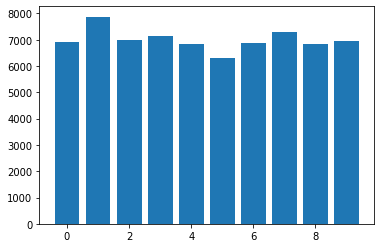

In [16]:
print(X.shape)
print(Y.shape)
unique, counts = np.unique(Y, return_counts=True)
plt.bar(unique, counts)

- Number of features: 784
- Number of instances: 70000
- Number of classes: 10
- Number of numerical features: 784
- Number of categorical features: 0

The dataset appears to be balanced, as there is a relatively similar number of samples in each of the 10 classes.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
ten = X_train.shape[0] / 10
subset_size = ten

sizes = []
dt_times = []
dt_accuracies = []
gb_times = []
gb_accuracies = []
for i in range(10):
  print('Current training classifiers with subset size', subset_size)
  subset = np.random.choice(len(X_train),
                            size=int(subset_size),
                            replace=False)
  X_train_subset = X_train[subset]
  Y_train_subset = Y_train[subset]

  decision_tree = DecisionTreeClassifier()
  start = time.time()
  decision_tree.fit(X_train_subset, Y_train_subset)
  stop = time.time()
  dt_times.append(stop - start)
  Y_pred = decision_tree.predict(X_test)
  dt_accuracies.append(accuracy_score(Y_test, Y_pred))

  gradient_boosting = GradientBoostingClassifier(max_depth=1, max_features=2)
  start = time.time()
  gradient_boosting.fit(X_train_subset, Y_train_subset)
  stop = time.time()
  gb_times.append(stop - start)
  Y_pred = gradient_boosting.predict(X_test)
  gb_accuracies.append(accuracy_score(Y_test, Y_pred))
  
  sizes.append(subset_size)
  subset_size += ten

pd.DataFrame({
    'Subset Size' : sizes,
    'Decision Tree Training Time' : dt_times,
    'Decision Tree Accuracies' : dt_accuracies,
    'Gradient Boosting Training Time' : gb_times,
    'Gradient Boosting Accuracies' : gb_accuracies,
})

Current training classifiers with subset size 5600.0
Current training classifiers with subset size 11200.0
Current training classifiers with subset size 16800.0
Current training classifiers with subset size 22400.0
Current training classifiers with subset size 28000.0
Current training classifiers with subset size 33600.0
Current training classifiers with subset size 39200.0
Current training classifiers with subset size 44800.0
Current training classifiers with subset size 50400.0
Current training classifiers with subset size 56000.0


,Subset Size,Decision Tree Training Time,Decision Tree Accuracies,Gradient Boosting Training Time,Gradient Boosting Accuracies
0,5600.0,1.167357,0.775000,3.304800,0.766571
1,11200.0,3.291267,0.814571,6.369983,0.768214
2,16800.0,5.081682,0.832714,9.666023,0.767143
3,22400.0,7.831322,0.842357,17.225468,0.765857
4,28000.0,12.945785,0.846429,16.477677,0.780143
5,33600.0,11.661200,0.856786,20.867682,0.776643
6,39200.0,20.156879,0.859143,24.273227,0.787714
7,44800.0,23.954294,0.861286,27.547377,0.773786
8,50400.0,26.379523,0.869643,31.403600,0.767286
9,56000.0,31.041935,0.870857,35.079876,0.767571


Text(0, 0.5, 'Accuracy')

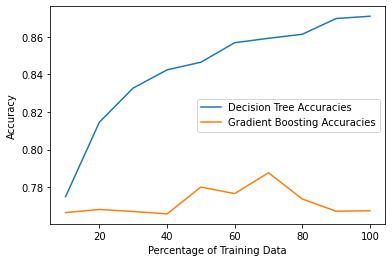

In [18]:
percentages = (np.array(sizes) / 560).astype(int)

plt.plot(percentages, dt_accuracies)
plt.plot(percentages, gb_accuracies)
plt.legend(['Decision Tree Accuracies',
            'Gradient Boosting Accuracies'])
plt.xlabel('Percentage of Training Data')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Time in seconds')

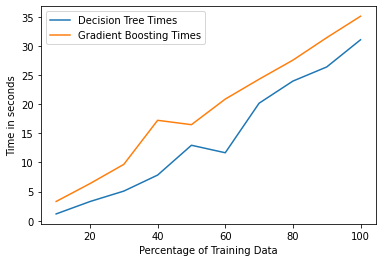

In [19]:
plt.plot(percentages, dt_times)
plt.plot(percentages, gb_times)
plt.legend(['Decision Tree Times',
            'Gradient Boosting Times'])
plt.xlabel('Percentage of Training Data')
plt.ylabel('Time in seconds')

Based on the two graphs above, it seems that larger training data will lead to a more accurate classifier, but the tradeoff is that the training time of the classifier also increases. Interestingly, when the training data is small, the two classifiers have a similar accuracy and training time. However, as the size of the training data increases, the difference between these two classifiers also increases. In all cases it seems like the decision tree classifier is both more accurate, and requires a shorter training time. 